In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [99]:
associations_df = pd.read_csv("data/associations_df.csv")
lp_schedule = pd.read_csv("schedules/linear_programming_green.csv")
lp_schedule = lp_schedule.drop(columns=['idx'])
brute_force_schedule = pd.read_csv("schedules/green_schedule.csv")
brute_force_schedule = brute_force_schedule.drop(columns=['idx'])
worst_case_schedule = pd.read_csv("schedules/worst_case_schedule.csv")
worst_case_schedule = worst_case_schedule.drop(columns=['idx'])
basic_schedule = pd.read_csv("schedules/basic_planner.csv")
print(associations_df.columns)

Index(['node', 'job_id', 'forecast_id', 'transfer_time', 'throughput',
       'host_joules', 'link_joules', 'total_joules', 'avg_ci',
       'carbon_emissions'],
      dtype='object')


Filtered data for Job 1:
                             node  forecast_id  carbon_emissions
0       jgoldverg@gmail.com_ccuc            0          2.586010
3   jgoldverg@gmail.com_system76            0          2.565094
6       jgoldverg@gmail.com_tacc            0          2.719319
9       jgoldverg@gmail.com_ccuc            1          2.558928
12  jgoldverg@gmail.com_system76            1          2.538231


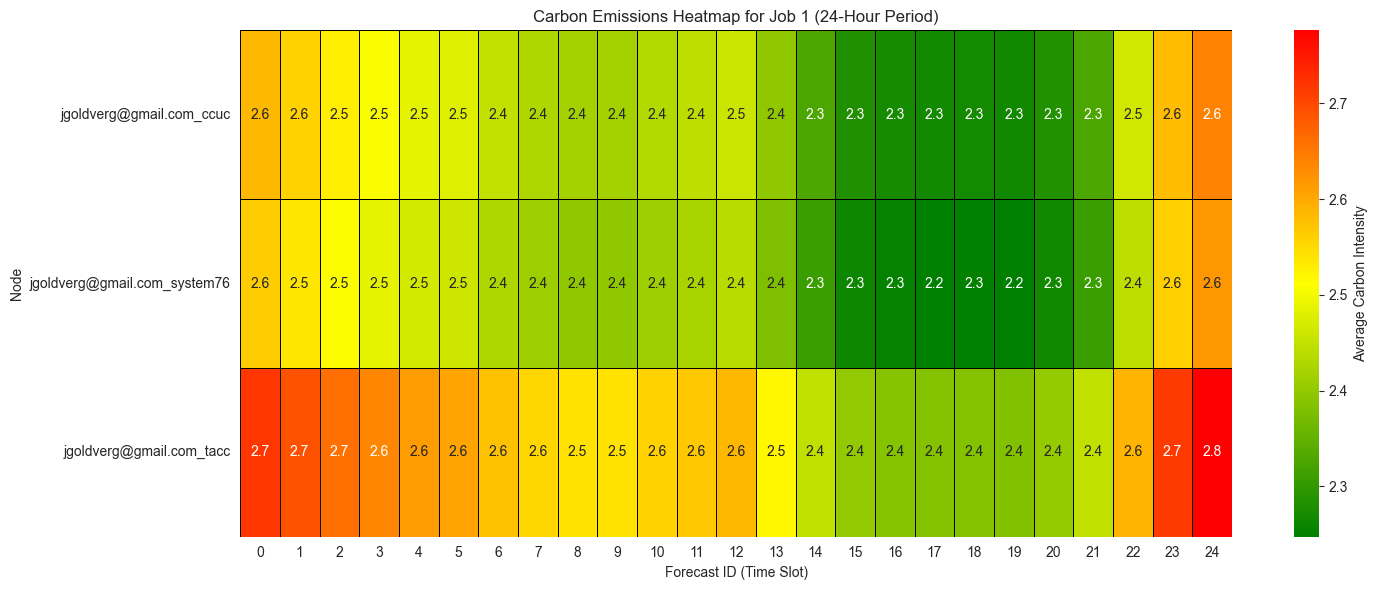

Filtered data for Job 2:
                             node  forecast_id  carbon_emissions
2       jgoldverg@gmail.com_ccuc            0       2779.607077
5   jgoldverg@gmail.com_system76            0       2762.932342
8       jgoldverg@gmail.com_tacc            0       2885.908403
11      jgoldverg@gmail.com_ccuc            1       2750.497666
14  jgoldverg@gmail.com_system76            1       2733.997557


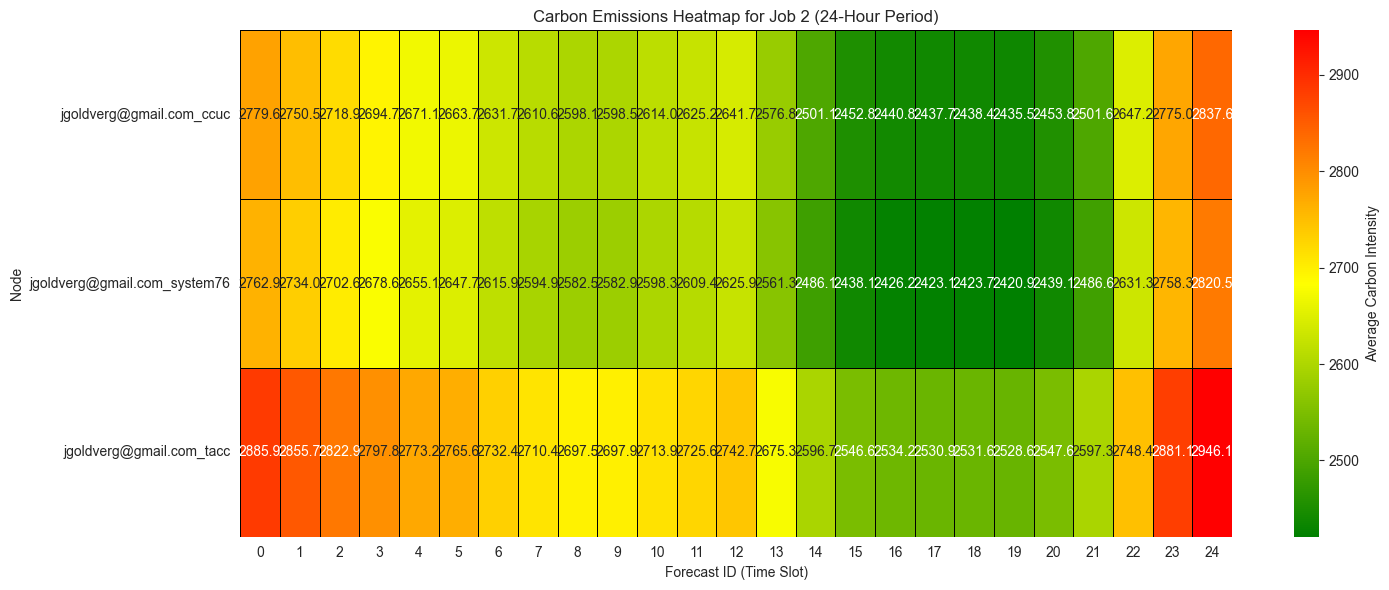

Filtered data for Job 3:
                             node  forecast_id  carbon_emissions
1       jgoldverg@gmail.com_ccuc            0         30.081165
4   jgoldverg@gmail.com_system76            0         29.895325
7       jgoldverg@gmail.com_tacc            0         31.265683
10      jgoldverg@gmail.com_ccuc            1         29.766140
13  jgoldverg@gmail.com_system76            1         29.582246


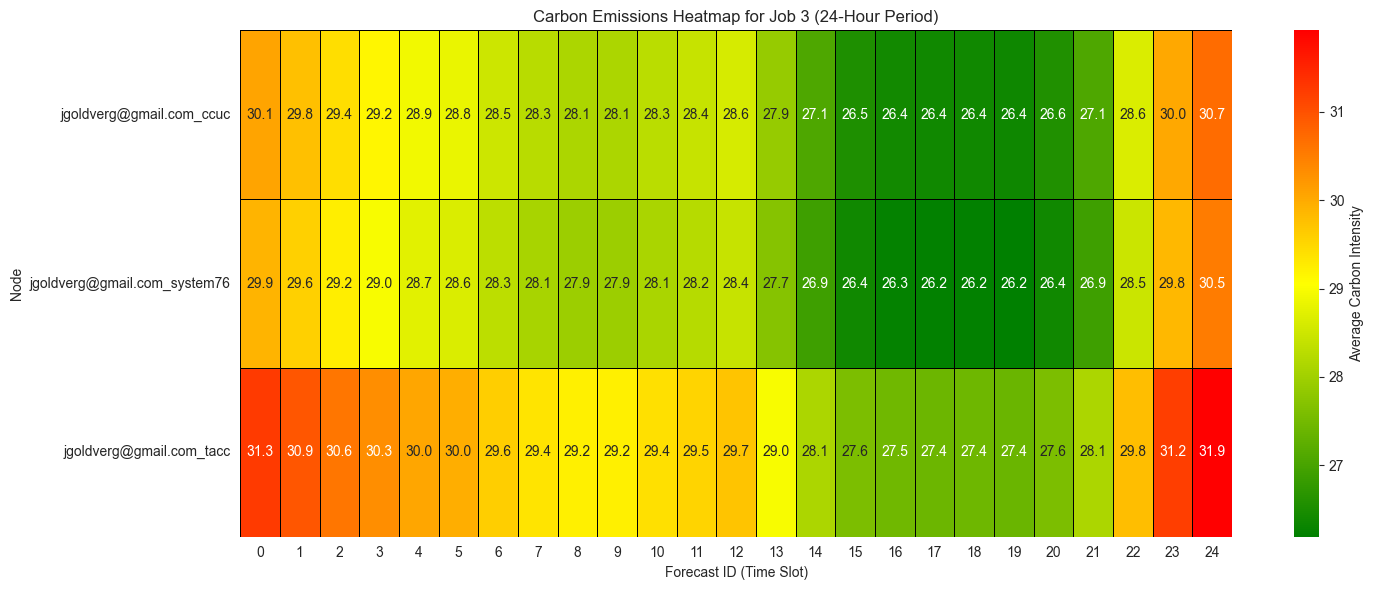

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

def visualize_job_carbon_intensity(associations_df, job_id):
    # Filter for the specified job
    job_df = associations_df[associations_df['job_id'] == job_id]

    # Check the filtered data
    print(f"Filtered data for Job {job_id}:\n", job_df[['node', 'forecast_id', 'carbon_emissions']].head())

    # Pivot the data for heatmap format
    heatmap_data = job_df.pivot(index='node', columns='forecast_id', values='carbon_emissions')

    # Define a color map (green = low, red = high)
    cmap = mcolors.LinearSegmentedColormap.from_list("carbon_intensity_cmap", ["green", "yellow", "red"])

    # Normalize based on min/max avg_ci
    norm = mcolors.Normalize(vmin=job_df['carbon_emissions'].min(), vmax=job_df['carbon_emissions'].max())

    # Plot the heatmap
    plt.figure(figsize=(15, 6))
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        norm=norm,
        annot=True,
        fmt=".1f",
        cbar_kws={'label': 'Average Carbon Intensity'},
        linewidths=0.5,
        linecolor='black'
    )

    # Customize the plot
    plt.xlabel('Forecast ID (Time Slot)')
    plt.ylabel('Node')
    plt.title(f'Carbon Emissions Heatmap for Job {job_id} (24-Hour Period)')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [101]:
def visualize_schedule(schedule_df, associations_df, name):
    # Get unique nodes and time slots (forecast_id)
    nodes = associations_df['node'].unique()
    time_slots = range(24)  # 0 to 23 (24-hour period)

    # Create a grid of all nodes and time slots
    grid_df = pd.DataFrame([(node, t) for node in nodes for t in time_slots], columns=['node', 'forecast_id'])

    # Merge with schedule_df to get job assignments
    grid_df = grid_df.merge(
        schedule_df[['node', 'forecast_id', 'job_id', 'carbon_emissions']],
        on=['node', 'forecast_id'],
        how='left'
    )

    # Fill NaN job_id with -1 (no job scheduled) and NaN carbon_emissions with 0
    grid_df['job_id'] = grid_df['job_id'].fillna(-1)
    grid_df['carbon_emissions'] = grid_df['carbon_emissions'].fillna(0)

    # Aggregate data for each node and forecast_id
    aggregated_df = grid_df.groupby(['node', 'forecast_id'], as_index=False).agg({
        'job_id': lambda x: ', '.join(map(str, x[x != -1])),  # Combine job_ids
        'carbon_emissions': 'sum'  # Sum carbon_emissions
    })

    # Fill empty job_id combinations with '-1'
    aggregated_df['job_id'] = aggregated_df['job_id'].replace('', '-1')

    # Pivot the grid to create a heatmap-friendly format
    heatmap_data = aggregated_df.pivot(index='node', columns='forecast_id', values='carbon_emissions')
    job_data = aggregated_df.pivot(index='node', columns='forecast_id', values='job_id')

    # Define a color map for carbon emissions (green to red)
    cmap = mcolors.LinearSegmentedColormap.from_list("emissions_cmap", ["green", "yellow", "red"])
    norm = mcolors.Normalize(vmin=associations_df['carbon_emissions'].min(),
                             vmax=associations_df['carbon_emissions'].max())

    # Plot the heatmap
    plt.figure(figsize=(15, 6))
    sns.heatmap(
        heatmap_data,
        cmap=cmap,  # Color map for carbon emissions
        norm=norm,  # Normalize emissions values
        annot=job_data,  # Show job IDs in cells
        fmt="",  # No special formatting for annotations
        cbar_kws={'label': 'Carbon Emissions'},
        linewidths=0.5,
        linecolor='black',
        mask=(job_data == '-1')  # Mask empty slots
    )

    # Customize the plot
    plt.xlabel('Forecast ID (Time Slot)')
    plt.ylabel('Node')
    plt.title(f'Job Schedule Heatmap (24-Hour Period) - Colored by Carbon Emissions using {name}')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

Linear Programming created a total emissions of 7179.05031695869
Brute Force created a total emissions of 7301.396911838062
Worst Case created a total emissions of 8657.37176219267
Basic Case created a total emissions of 8281.700221524823


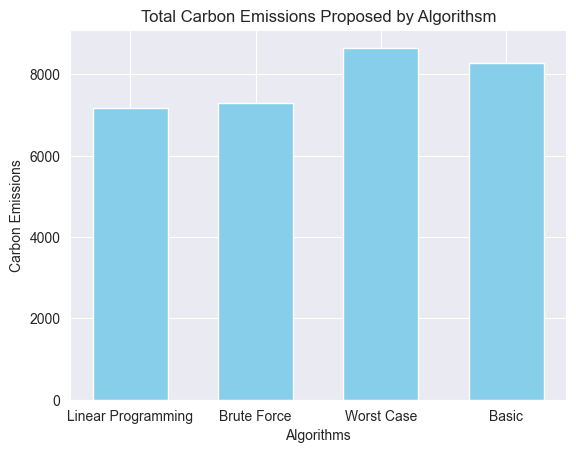

In [107]:
def total_emissions_schedule(schedule_df, schedule_name):
    total = schedule_df['carbon_emissions'].sum()
    print(f"{schedule_name} created a total emissions of {schedule_df['carbon_emissions'].sum()}")
    return total


lp_total_ce = total_emissions_schedule(lp_schedule, "Linear Programming")
brute_total_ce = total_emissions_schedule(brute_force_schedule, "Brute Force")
worst_total_ce = total_emissions_schedule(worst_case_schedule, "Worst Case")
basic_total_ce = total_emissions_schedule(basic_schedule, "Basic Case")
total_ce_list = [lp_total_ce, brute_total_ce, worst_total_ce, basic_total_ce]
plt.bar(["Linear Programming", "Brute Force", "Worst Case", "Basic"], total_ce_list, color='skyblue', width=0.6)
plt.xlabel("Algorithms")
plt.ylabel("Carbon Emissions")
plt.title("Total Carbon Emissions Proposed by Algorithms")
plt.show()

Filtered data for Job 1:
                             node  forecast_id  carbon_emissions
0       jgoldverg@gmail.com_ccuc            0          2.586010
3   jgoldverg@gmail.com_system76            0          2.565094
6       jgoldverg@gmail.com_tacc            0          2.719319
9       jgoldverg@gmail.com_ccuc            1          2.558928
12  jgoldverg@gmail.com_system76            1          2.538231


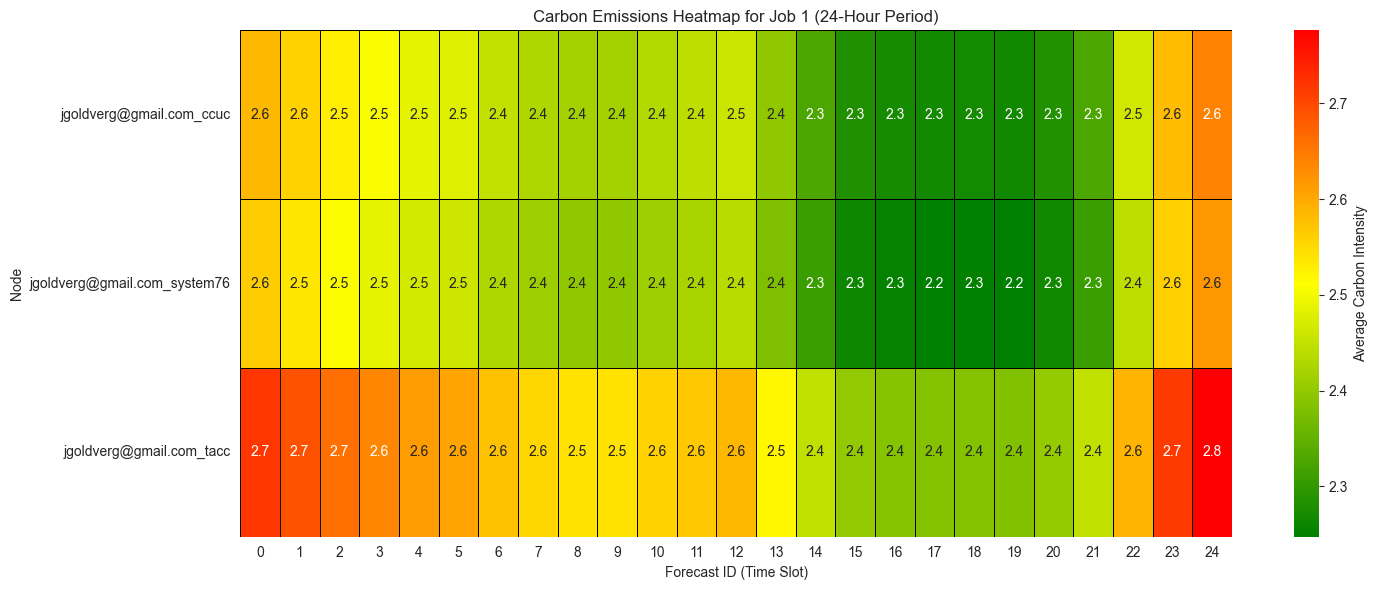

Filtered data for Job 2:
                             node  forecast_id  carbon_emissions
2       jgoldverg@gmail.com_ccuc            0       2779.607077
5   jgoldverg@gmail.com_system76            0       2762.932342
8       jgoldverg@gmail.com_tacc            0       2885.908403
11      jgoldverg@gmail.com_ccuc            1       2750.497666
14  jgoldverg@gmail.com_system76            1       2733.997557


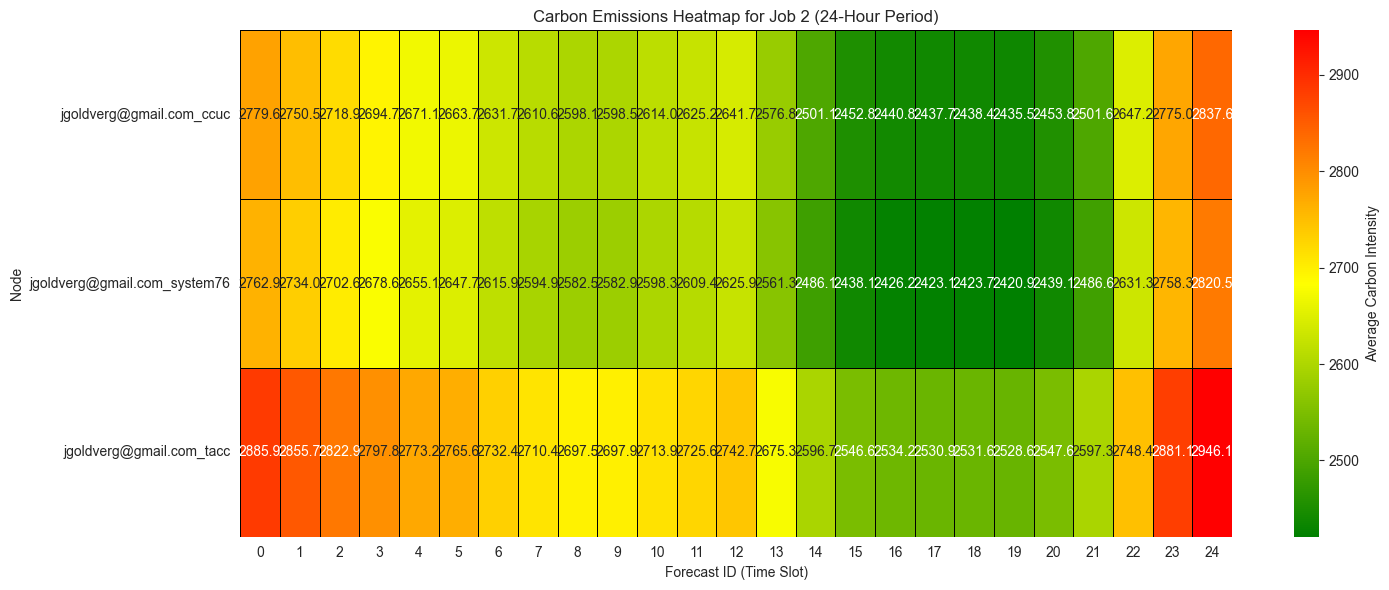

Filtered data for Job 3:
                             node  forecast_id  carbon_emissions
1       jgoldverg@gmail.com_ccuc            0         30.081165
4   jgoldverg@gmail.com_system76            0         29.895325
7       jgoldverg@gmail.com_tacc            0         31.265683
10      jgoldverg@gmail.com_ccuc            1         29.766140
13  jgoldverg@gmail.com_system76            1         29.582246


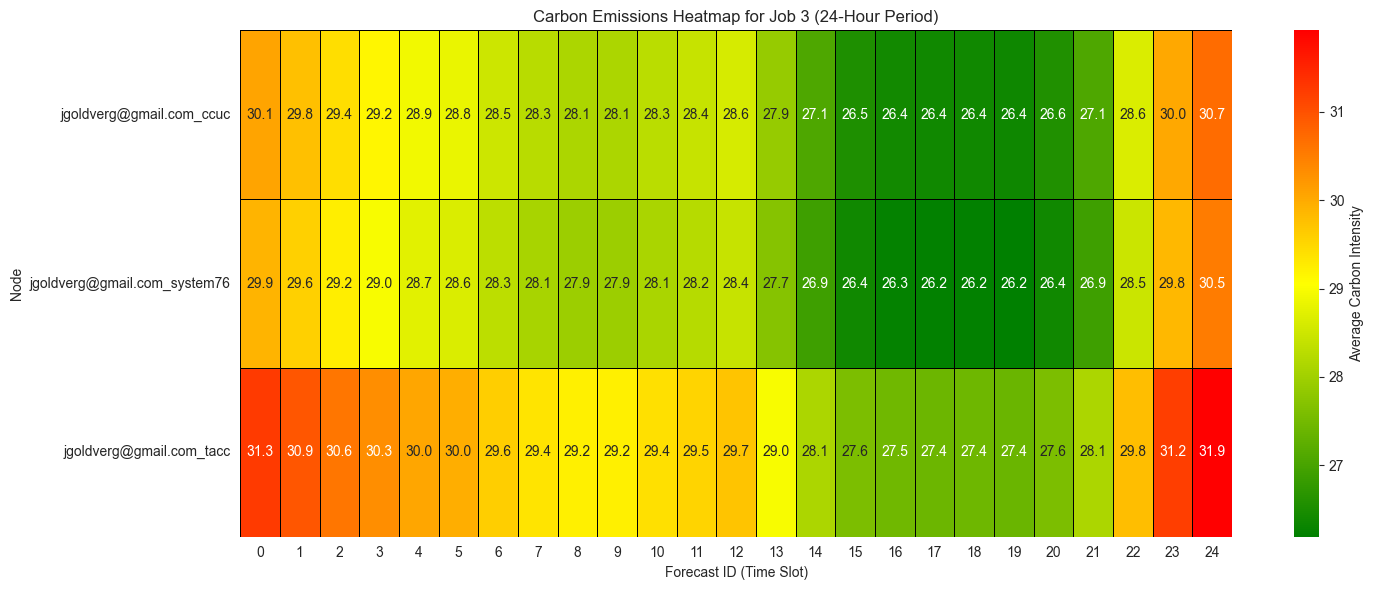

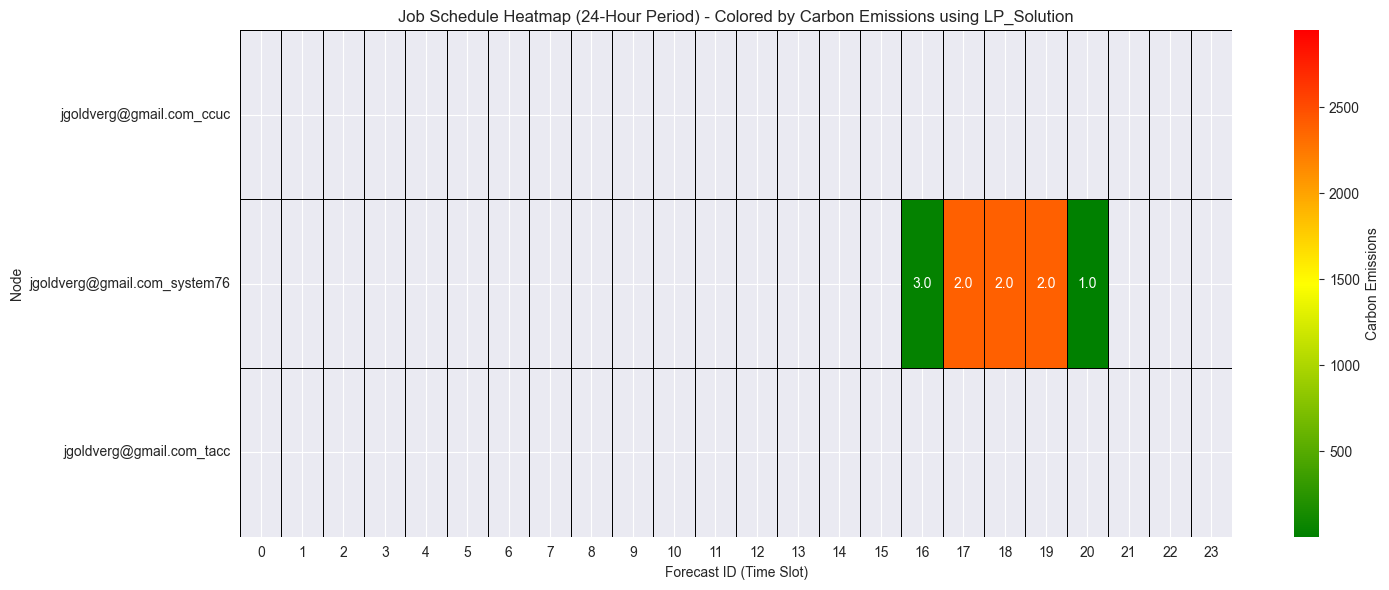

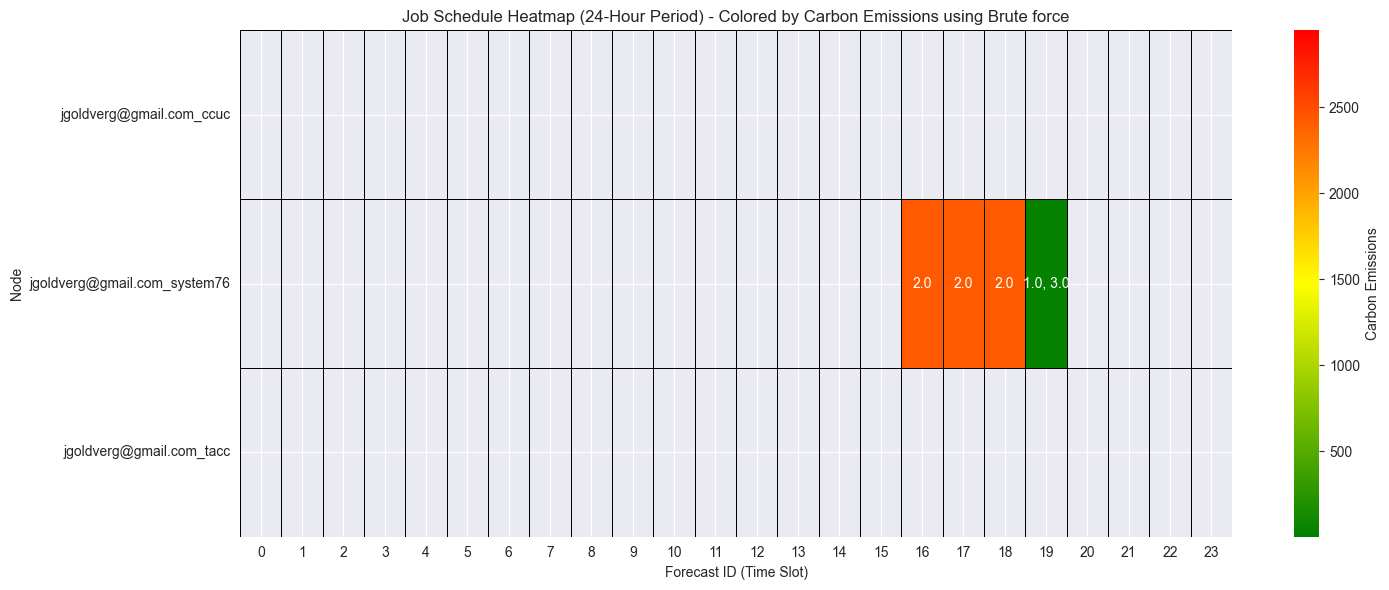

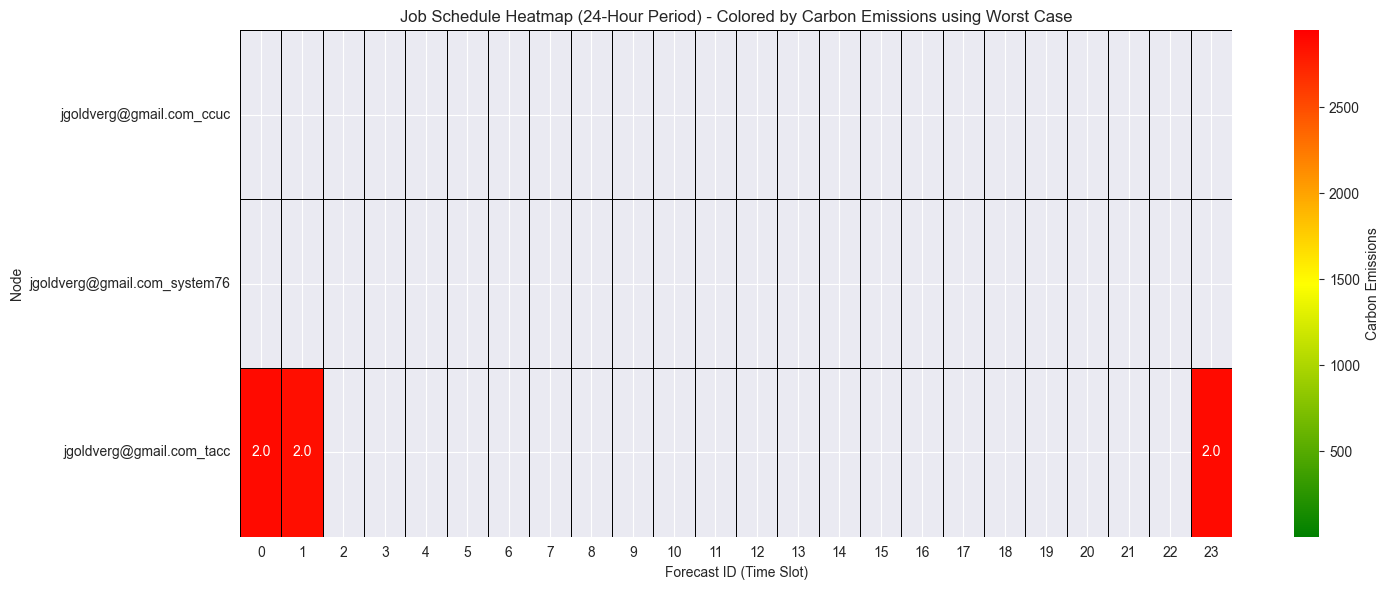

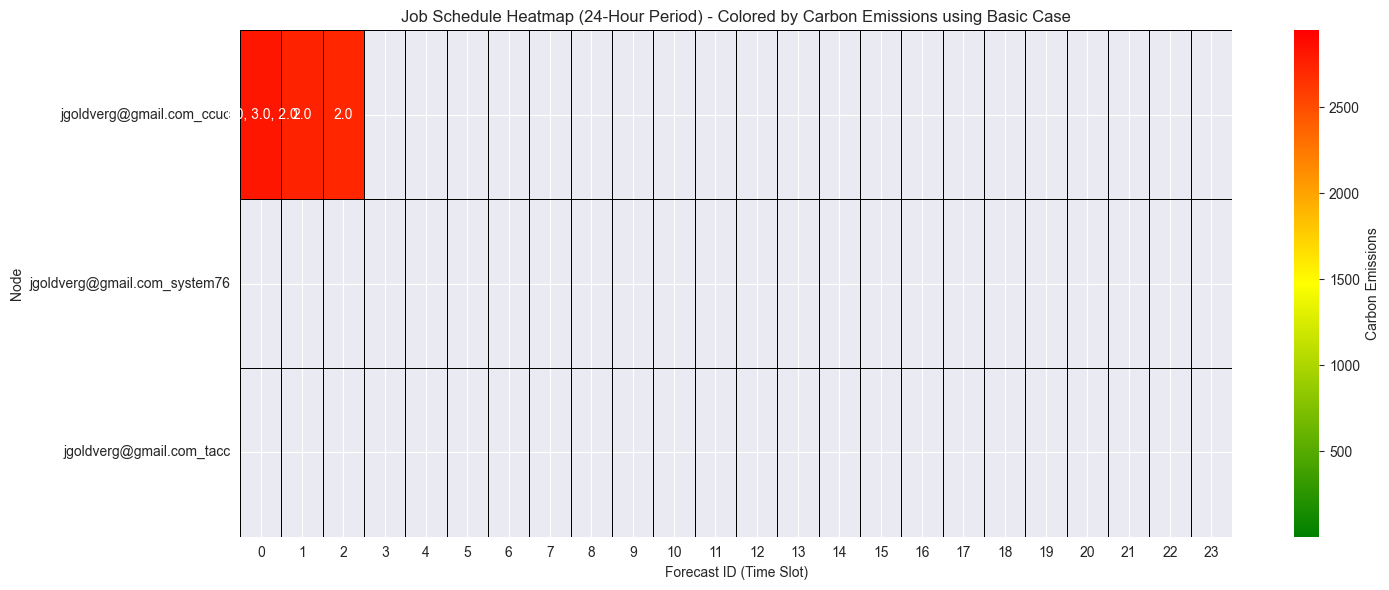

In [108]:
##Visualiatioins

visualize_job_carbon_intensity(associations_df, 1)
visualize_job_carbon_intensity(associations_df, 2)
visualize_job_carbon_intensity(associations_df, 3)
##Schedule visualizations
visualize_schedule(lp_schedule, associations_df, "LP_Solution")
visualize_schedule(brute_force_schedule, associations_df, "Brute force")
visualize_schedule(worst_case_schedule, associations_df, "Worst Case")
visualize_schedule(basic_schedule, associations_df, "Basic Case")